In [1]:
%load_ext autoreload
%autoreload 2

`Author: Victor Radermecker`

## Confidence Intervals Packages - MIT Research

This Jupyter Notebook is a tutorial on how to use the matrix completion package delivered by MIT to Liberty Mutual. It includes the following features:

<div style="padding: 20px; border: 5px solid orange; max-width: 1200px;">

# Synthetic Dataset Generator

This Jupyter Notebook explains how the SyntheticDataset class works. The class generates synthetic datasets using low-rank matrix decomposition and introduces missing values in the data.

### Class: SyntheticDataset
```python
import numpy as np
import pandas as pd

class SyntheticDataset:
    ...
```

### Initialization
The class constructor initializes the synthetic dataset generator with the following parameters:

- n (int): The number of rows in the dataset
- m (int): The number of columns in the dataset
- r (int): The rank of the low-rank matrix decomposition
- noise_std (float): The standard deviation of the noise added to the matrix
- min_prop (float): The minimum proportion of missing values in each column
- max_prop (float): The maximum proportion of missing values in each column
- num_categorical (int): The number of categorical columns in the dataset

```python
def __init__(self, n=1000, m=40, r=10, noise_std=0.1, min_prop=0.1, max_prop=0.3, num_categorical=5):
    ...
```

### Generating the Dataset
The generate method generates a synthetic dataset with missing values using low-rank matrix decomposition and returns it as a Pandas DataFrame. The first `num_categorical` columns are converted into categorical columns.

```python
def generate(self):
    ...
```

### Hiding Values

The _hide_values method is a private method that hides a random proportion of values in each column of a 2D numpy array by replacing them with NaN. The proportion of missing values in each column is randomly chosen between min_prop and max_prop.

```python
def _hide_values(self, array, min_prop, max_prop):
    ...
```

### Usage
To use the SyntheticDataset class, simply create an instance of the class with the desired parameters and call the generate method to generate a synthetic dataset.

```python
generator = SyntheticDataset(n=1000, m=40, r=10, noise_std=0.1, min_prop=0.1, max_prop=0.3)
synthetic_data = generator.generate()
```

The resulting synthetic_data is a Pandas DataFrame containing the generated synthetic dataset with missing values.


</div>

<div style="padding: 20px; border: 5px solid orange; max-width: 1200px;">

# Matrix Completion and Confidence Intervals

### Class: MatrixCompletionFast 

The constructor method of the MatrixCompletionFast class initializes the object with several parameters including:

```python
class MatrixCompletionFast:
    ...
```

Here is a description of all parameters needed to initialize the model.
- data (Pandas Dataframe): the input dataset to be imputed.
- train_prop (float): the proportion of the data to be used for training.
- factors (int): the number of factors to use for imputation.
- nbr_batches (int): the number of batches to divide the dataset into for parallel processing.
- val_prop (float): the proportion of the training data to be used for validation.
- n_jobs: the number of parallel jobs to use during matrix completion. Default is -1, which means to use all available processors. Not fully functional yet, @TODO.
- random_seed: the random seed to use for reproducibility.


<div style="color:red; font-size: 16px; padding: 10px; background-color: rgba(255, 0, 0, 0.1); border: 1px solid rgba(255, 0, 0, 0.5); max-width: 1150px;">
    <strong>Important:</strong> In order to avoid the low-matrix decomposition to be skewed by some larger features, make sure to normalize the dataset before feeding it into this model.
</div>

### Matrix Imputation - Usage

##### Import the MatrixCompletion class from the MCF package:

Create an instance of the MatrixCompletion class, and use the impute_dataframe() function to impute missing values in a pandas DataFrame. This function imputes missing values in the input dataframe using hard imputation. If keep_missing_only is True, only missing values will be imputed. 

```python
from MCF import MatrixCompletion
mc = MatrixCompletion()
imputed_df = mc.impute_dataframe(keep_missing_only=True)
```

### Confidence Intervals - Usage

Two paramters are needed to initialize the confidence interval model:
- `conf_level`: the confidence level to use for the confidence intervals. A list of various confidence levels is recommended, so then the optimal can be chosen later.
- `beta`: the beta parameter allows to artificially inflate the confidence intervals. Indeed, we are usually computing the confidence of the *prediction*, but this prediction may be very different than the true value to estimate. Suppose that you use the baseline, the mean imputation. A very narrow confidence interval indicate that we are certain about the mean value, but this doesn't mean that the imputed value will indeed be in that confidence interval. Therefore, artificially increasing the size of the interval until reaching an acceptable coverage rate is recommened. Based on experiments, a value of $beta=4$ seems appropriate. 

The method to compute the confidence intervals for the three available methods: baseline (mean imputation), bootstrapping and MIT uncertainty quantification paper is the following:

```python
MCF.confidence_intervals(conf_lvls, beta=4)
```

The confidence interval method takes some time, and if everything went well, the following message will be displayed:

```python
Success. Exit.
```

The results can be extracted using:
```python
baseline, bootstrap, mit = MCF.summarize_results()
```

And some visualiztions are obtained using:
```python
MCF.plot_results_feature()
```

</div>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
pd.set_option("display.max_rows", 500)
pd.set_option('display.max_columns', 500)

from src.synthetic_data import *
from src.matrix_completion_fast import *

# Synth Dataset

Initial experiments on the synthetic dataset.

`1) Generate the synthetic dataset`

In [8]:
# Instantiate the SyntheticDataset class with the provided parameters
synth_generator = SyntheticDataset(n=2000, m=20, r=10, noise_std=0.1, min_prop=0.2, max_prop=0.2, num_categorical=0)

# Generate the synthetic dataset
synth_df = synth_generator.generate()

# Convert the synthetic dataset to a numpy array
np_synth = synth_df.to_numpy()

# Print the first 10 rows of the synthetic dataset
synth_df.head(10)

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19
0,0.083506,0.243556,0.208067,0.355440,0.105832,-1.387258,-0.486256,-0.491276,-0.670912,0.249737,0.053538,-0.402888,-0.257413,NaN,NaN,-0.852889,-0.532897,NaN,NaN,NaN
1,-0.784451,0.619781,0.026929,-0.245336,-0.747249,-1.701985,-0.627436,-0.654606,-0.065941,-0.204256,-0.173782,-1.191466,-0.691262,0.363888,-0.477652,-1.875383,-1.792015,-0.812986,-0.494393,NaN
2,-0.650478,NaN,-0.287263,-0.250420,-0.026296,-1.927808,NaN,0.267778,NaN,-0.022856,0.552075,NaN,-0.575887,NaN,-0.189654,NaN,-0.705114,-0.276591,-1.471138,-0.391825
3,0.791986,0.989869,NaN,NaN,1.079148,-0.226687,NaN,0.746037,0.791741,NaN,2.528499,0.004638,-0.324252,1.324083,NaN,NaN,-0.431075,0.842138,NaN,1.429300
4,0.720752,0.537154,NaN,0.537587,0.597037,NaN,-0.593012,0.857997,0.801135,0.954267,1.492310,0.206351,-0.129704,0.601786,1.031193,-0.660087,-0.709929,0.301635,NaN,0.627889
5,-1.239634,-0.433485,-1.063108,-1.108330,-0.746361,-2.635480,-1.886378,-0.340961,-0.758527,-0.585179,-0.148391,-1.367446,-1.134760,-0.536720,-0.615068,NaN,-1.962385,-1.071217,-1.274824,-0.384104
6,-0.025539,0.435223,-0.279851,-0.633274,NaN,-1.987476,-0.707158,0.711287,-0.042755,0.294743,0.762352,-0.837355,-1.140453,-0.254137,-0.223970,-1.639622,-1.521694,NaN,-0.229676,-0.043912
7,0.052262,NaN,-0.495078,NaN,-1.081685,NaN,-1.097218,-0.044794,-0.389548,0.037148,0.462025,-0.698123,NaN,NaN,-0.063050,-1.207819,-1.616935,-0.247788,-0.700445,0.522711
8,2.181878,2.025254,1.560867,1.612477,NaN,NaN,0.326935,1.658645,1.150068,2.063675,3.746906,0.590790,0.531471,1.839745,2.146968,0.174258,-0.236601,0.644981,0.800274,NaN
9,0.157023,1.310557,0.928311,0.158571,0.341530,NaN,0.467829,0.574681,NaN,1.029320,0.743603,-0.559923,0.349225,0.806650,0.191286,-0.493085,-0.875564,0.676579,-0.136114,1.052405


`2) Instantiate the MatrixCompletionFast Object`

In [10]:
factors = list(range(6,12))

MCF = MatrixCompletionFast(
    data=synth_df,
    factors=factors,
    val_prop=0.1)

   val  train  miss  total
0  160   1440   400   2000
1  160   1440   400   2000
2  160   1440   400   2000
3  160   1440   400   2000
4  160   1440   400   2000 

Number of validation points: 3200
Number of training points: 28800
Number of missing points: 8000 

Range of factors specified. Optimizing factors...
Average R^2 score for 6 factors: 0.7989
Average R^2 score for 7 factors: 0.8248
Average R^2 score for 8 factors: 0.8182
Average R^2 score for 9 factors: 0.8383
Average R^2 score for 10 factors: 0.7912
Average R^2 score for 11 factors: 0.6585
The optimal number of factors is 9. 

New factor successfully saved.


In [11]:
# Check the R^2 for each feature for various factors
MCF.r2_scores_df

,Factor: 6,Factor: 7,Factor: 8,Factor: 9,Factor: 10,Factor: 11
col0,0.798142,0.804667,0.797137,0.845634,0.834327,0.782867
col1,0.869026,0.868686,0.864594,0.864122,0.823498,0.754536
col2,0.913157,0.919065,0.922238,0.933392,0.913195,0.898644
col3,0.897679,0.920974,0.916801,0.925248,0.919361,0.914305
col4,0.845356,0.863692,0.841381,0.856695,0.856260,0.827224
col5,0.493531,0.592568,0.592408,0.538865,0.470812,-1.610911
col6,0.878998,0.912107,0.907063,0.925017,0.905174,0.885718
col7,0.873871,0.880511,0.888724,0.892027,0.867344,0.838398
col8,0.713552,0.700067,0.643197,0.783876,0.748290,0.710133
col9,0.869561,0.874300,0.876688,0.890737,0.859235,0.861193


`2) Run one imputation over the dataset`

In [12]:
df_imputed = MCF.impute_dataframe(keep_missing_only=True)
df_imputed.head()

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19
0,0.083506,0.243556,0.208067,0.355440,0.105832,-1.387258,-0.486256,-0.491276,-0.670912,0.249737,0.053538,-0.402888,-0.257413,0.000000,0.000000,-0.852889,-0.532897,0.000000,0.000000,0.000000
1,-0.784451,0.619781,0.026929,-0.245336,-0.747249,-1.701985,-0.627436,-0.654606,-0.065941,-0.204256,-0.173782,-1.191466,-0.691262,0.363888,-0.477652,-1.875383,-1.792015,-0.812986,-0.494393,0.000000
2,-0.650478,0.000000,-0.287263,-0.250420,-0.026296,-1.927808,0.000000,0.267778,0.000000,-0.022856,0.552075,0.000000,-0.575887,0.000000,-0.189654,0.000000,-0.705114,-0.276591,-1.471138,-0.391825
3,0.791986,0.989869,0.000000,0.000000,1.079148,-0.226687,0.000000,0.746037,0.791741,0.000000,2.528499,0.004638,-0.324252,1.324083,0.000000,0.000000,-0.431075,0.842138,0.000000,1.429300
4,0.720752,0.537154,0.000000,0.537587,0.597037,0.000000,-0.593012,0.857997,0.801135,0.954267,1.492310,0.206351,-0.129704,0.601786,1.031193,-0.660087,-0.709929,0.301635,0.000000,0.627889


`3) Compute confidence intervals`

#### What is the beta parameter?

When we compute confidence intervals, we quantify the uncertainty of the predicted value. However, we may be extremely sure about the predicted value, and still miss the prediction. For example, let's suppose that we impute with the mean, and we know the mean's exact value with a confidence of 0.9999. If the true value to impute is far away from the mean, our 0.9999 confidence on the mean value doesn't lead to a coverage of 0.9999.

In the future, if LibertyMutuals wants to ensure a coverage rate of 0.9 (for example), we can find the value of beta for each feature that ensure that coverage.

In [152]:
conf_lvls = [
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.975,
    0.98,
    0.99,
    0.999,
    0.9999,
]

MCF.confidence_intervals(
    conf_lvls, train_prop=0.7, nbr_batches=10, beta=4
)

   val  train  miss  total
0  160   1440   400   2000
1  160   1440   400   2000
2  160   1440   400   2000
3  160   1440   400   2000
4  160   1440   400   2000 

Number of validation points: 3200
Number of training points: 28800
Number of missing points: 8000 

Imputing full matrix...
Imputation finished. 

Running imputation on all training batches...


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Imputation on training data finished. 

Computing confidence intervals for all validation points...


100%|██████████| 17/17 [00:00<00:00, 3177.64it/s]


Confidence intervals computed. 

Computing coverage for all validation points...


100%|██████████| 3200/3200 [00:00<00:00, 83767.76it/s]


Coverage computed. 

Success. Exit.


In [153]:
baseline, bootstrap, mit = MCF.summarize_results()

In [154]:
baseline.head()

,feature,confidence_level,length,cov,method
0,0,0.1,0.015588,0.00625,Baseline
1,0,0.2,0.031426,0.02500,Baseline
2,0,0.3,0.047797,0.03125,Baseline
3,0,0.4,0.065049,0.03750,Baseline
4,0,0.5,0.083667,0.04375,Baseline


In [155]:
bootstrap.head()

,feature,confidence_level,length,cov,method
0,0,0.1,0.020863,0.06875,Bootstrap
1,0,0.2,0.042063,0.16875,Bootstrap
2,0,0.3,0.063976,0.24375,Bootstrap
3,0,0.4,0.087069,0.37500,Bootstrap
4,0,0.5,0.111992,0.48125,Bootstrap


In [156]:
mit.head()

,feature,confidence_level,length,cov,method
0,0,0.1,0.006708,0.0125,MIT
1,0,0.2,0.013524,0.0375,MIT
2,0,0.3,0.020570,0.0500,MIT
3,0,0.4,0.027994,0.0750,MIT
4,0,0.5,0.036006,0.1000,MIT


# Some Analysis Plots

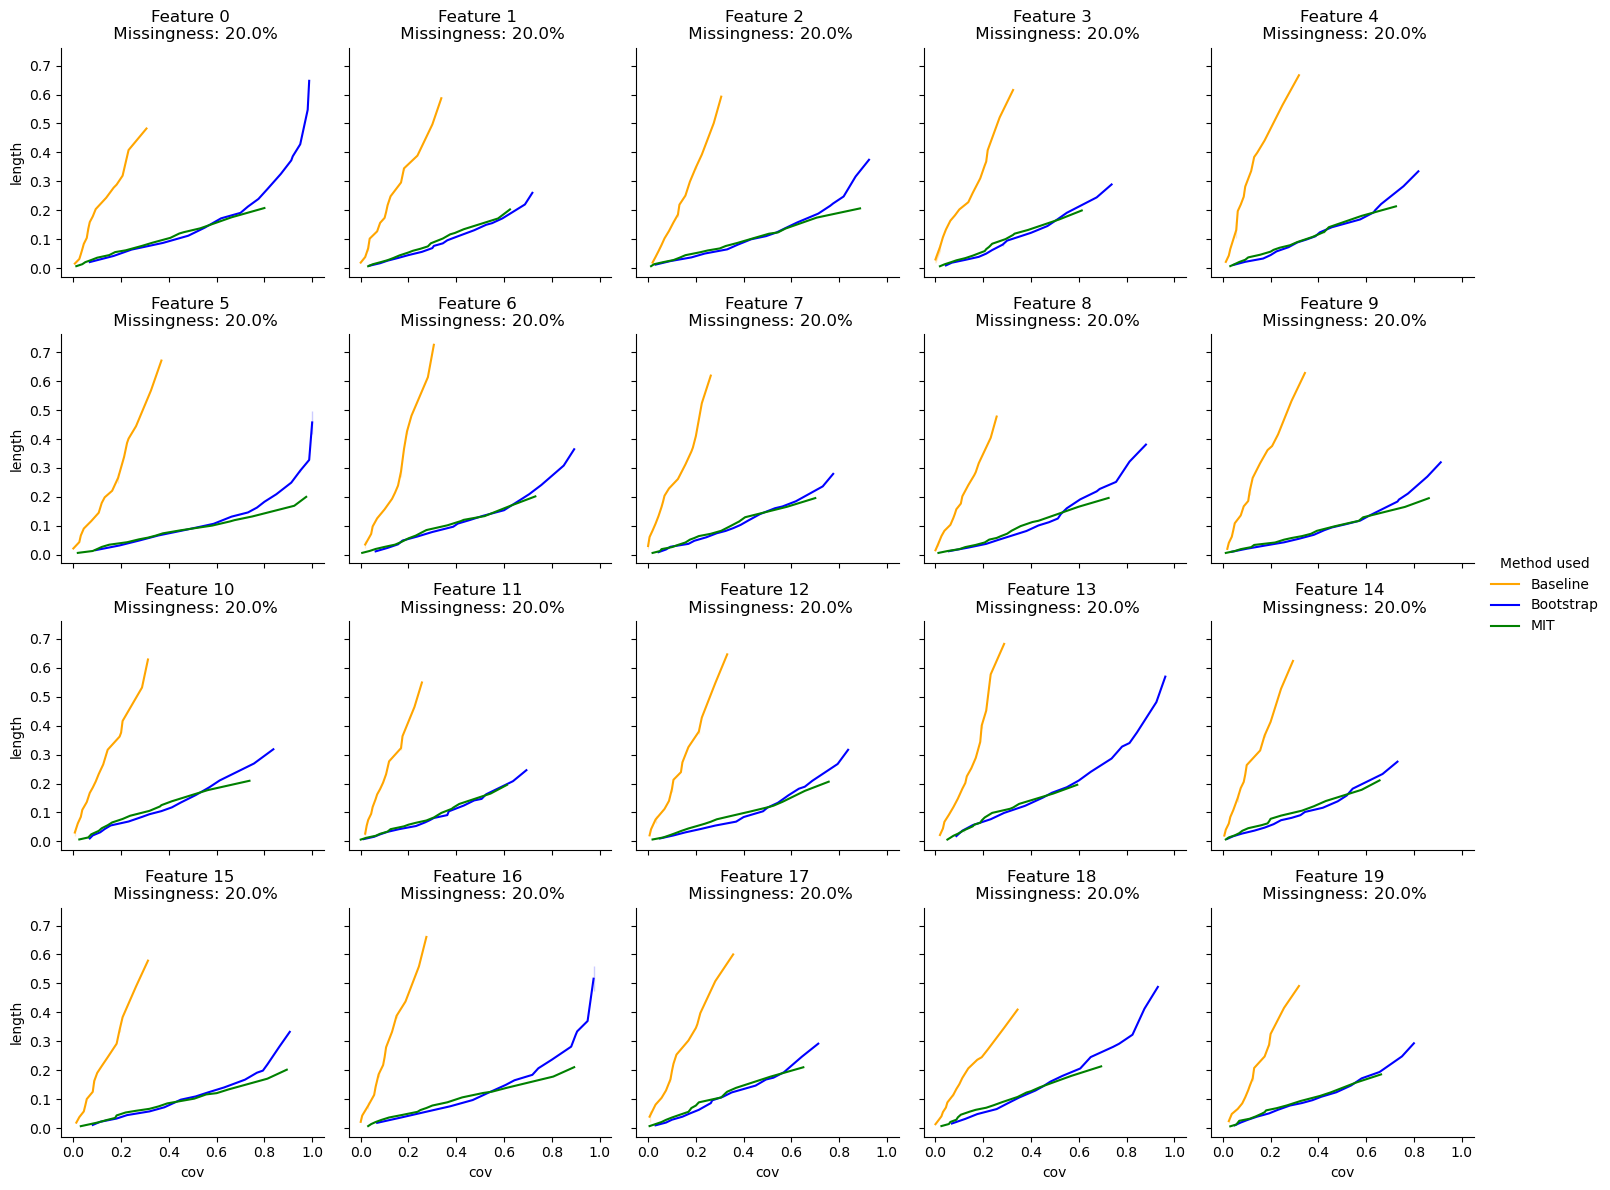

In [157]:
MCF.plot_results_feature()

### Extract the confidence intervals for one specific method only (Either Bootstrap or MIT)

`Here, we show how to extract the confidence intervals for all the missing values (imputed points).`

- Available methods: Baseline, Bootstrap, MIT.
- Recommended method: MIT.

In [158]:
confidence_intervals = MCF.get_cis(alpha=0.9, method="mit")
confidence_intervals.head()

100%|██████████| 8000/8000 [00:00<00:00, 209356.68it/s]


,indices,low,up,imputed
0,"[0, 15]",0.351617,0.422725,0.387171
1,"[0, 17]",-1.057518,-0.965818,-1.011668
2,"[0, 18]",-1.806393,-1.728971,-1.767682
3,"[1, 7]",-0.587424,-0.494192,-0.540808
4,"[1, 9]",-0.541609,-0.467463,-0.504536


# FastTrack dataset

The synthetic dataset is normalized by nature. To avoid a dominant effect of the features having larger values, we normalize the FastTrack dataset. These are the following steps to do.




`1) Load the FastTrack dataset`

We only keep the continuous features that are relevant to this analsis.

In [159]:
df = pd.read_csv("./Data/FastTrack.csv")  # (17381, 552)
features = pd.read_csv('./Data/FT_coltokeep.csv', header=None) # keep specific features only
df = df[features[0]]
df = df.dropna(axis=1, how='all')

In [160]:
df.head()

,ID,FTP_IsNew1Renewal2,FTP_WrittenLine,FTP_policy_period,FTP_policy_period_rate,BvD_firmographicsindustry_classificationsussicpcod,BvD_financialsindustry_global_financials_and_ratios_usdclosdate,BvD_financialsindustry_global_financials_and_ratios_usdcash,BvD_financialsindustry_global_financials_and_ratios_usdtoas,BvD_financialsindustry_global_financials_and_ratios_usdculi,BvD_financialsindustry_global_financials_and_ratios_usdocli,BvD_financialsindustry_global_financials_and_ratios_usdebma,BvD_financialsindustry_global_financials_and_ratios_usdoppl,BvD_financialsindustry_global_financials_and_ratios_usdinte,BvD_financialsindustry_global_financials_and_ratios_usdtaxa,BvD_financialsindustry_global_financials_and_ratios_usdpl,BvD_financialsindustry_global_financials_and_ratios_usdncli,BvD_financialsindustry_global_financials_and_ratios_usdoncl,BvD_financialsindustry_global_financials_and_ratios_usdprma,BvD_financialsindustry_global_financials_and_ratios_usdtfas,BvD_financialsindustry_global_financials_and_ratios_usdplat,BvD_financialsindustry_global_financials_and_ratios_usdosfd,BvD_financialsindustry_global_financials_and_ratios_usdshfd,BvD_financialsindustry_global_financials_and_ratios_usdopre,BvD_financialsindustry_global_financials_and_ratios_usdfire,BvD_financialsindustry_global_financials_and_ratios_usdexre,BvD_financialsindustry_global_financials_and_ratios_usdexpt,BvD_closedate_missing,BvD_closdatex,BvD_nr_monthsx,BvD_exchratex,BvD_fias,BvD_ifas,BvD_tfas,BvD_ofas,BvD_cuas,BvD_stok,BvD_debt,BvD_ocas,BvD_cash,BvD_toasx,BvD_shfdx,BvD_capi,BvD_osfd,BvD_ncli,BvD_ltdb,BvD_oncl,BvD_prov,BvD_culi,BvD_loan,BvD_cred,BvD_ocli,BvD_tshf,BvD_wkca,BvD_ncas,BvD_enva,BvD_emplx,BvD_oprex,BvD_turn,BvD_cost,BvD_gros,BvD_oope,BvD_oppl,BvD_fire,BvD_fiex,BvD_fipl,BvD_plbtx,BvD_taxa,BvD_plat,BvD_exre,BvD_exex,BvD_extr,BvD_plx,BvD_expt,BvD_mate,BvD_staf,BvD_depr,BvD_inte,BvD_rd,BvD_cfx,BvD_av,BvD_ebta,BvD_rshfx,BvD_rcemx,BvD_rtas,BvD_roe,BvD_roce,BvD_roa,BvD_prmax,BvD_grma,BvD_etma,BvD_ebma,BvD_cfop,BvD_evet,BvD_mkcf,BvD_nat,BvD_ic,BvD_stot,BvD_coll,BvD_crpe,BvD_exop,BvD_rdop,BvD_currx,BvD_liqr,BvD_shlq,BvD_solrx,BvD_soll,BvD_gear,BvD_ppe,BvD_tpe,BvD_sct,BvD_ace,BvD_sfpe,BvD_wcpe,BvD_tape,BvD_opre_original,BvD_empl_original,BvD_conscode_desc,BvD_naceccod2,BvD_nacepcod2,BvD_nacescod2,BvD_naicsccod2017,BvD_naicspcod2017,BvD_naicsscod2017,BvD_ussicccod,BvD_ussicpcod,BvD_ussicscod,BvD_SIC_derive,BvD_closdatey,BvD_nr_monthsy,BvD_exchratey,BvD_oprey,BvD_plbty,BvD_ply,BvD_cfy,BvD_toasy,BvD_shfdy,BvD_curry,BvD_prmay,BvD_rshfy,BvD_rcemy,BvD_solry,BvD_kf_611,BvD_emply,BvD_astk_market_cap,BvD_namechdt,BvD_inactive,BvD_dateinc,BvD_delisted_date,BvD_ipo_date,BvD_historicaldate,CAPIQ_Fin_periodTypeId,CAPIQ_Fin_PublicPrivate,CAPIQ_Fin_formtype_rank,CAPIQ_Fin_consolidatedRank,CAPIQ_Fin_vendorRank,CAPIQ_Fin_TotalEquity,CAPIQ_Fin_NetIncomeMargin,CAPIQ_Fin_EBIT_IntExpense,CAPIQ_Fin_RetainedEarningsOverTotalAssets,CAPIQ_Fin_EBITMargin,CAPIQ_Fin_NetIncome1YrGrowth,CAPIQ_Fin_CashEquivalentsOverCurrentLiabilities,CAPIQ_Fin_CashEquivalentsOverTotalAssets,CAPIQ_Fin_IncomeTaxExpenseOverCurrentLiabilities,CAPIQ_Fin_NetIncomeOverTotalLiabilities,CAPIQ_Fin_NetPPEOverTotalAssets,CAPIQ_Fin_OperatingProfitAfterTaxOverCurrLiabilities,CAPIQ_Fin_CurrentLiabilities,CAPIQ_Fin_TotalAssets,CAPIQ_Fin_TotalLiabilities,CAPIQ_Fin_CurrentLiabilitiesOverNetWorth,CAPIQ_Fin_TotalEquityOverTotalAssets,CAPIQ_Fin_TotalRevenue,CAPIQ_Fin_InterestExpense,CAPIQ_Fin_PublicPrivateVendorRank,CAPIQ_Fin_countryId,CAPIQ_Fin_corporateIndustryRiskScore,CAPIQ_Fin_consumerPriceIndexGrowth,CAPIQ_Fin_countryRiskScore,CAPIQ_Fir_CapIQ_YearStarted,CAPIQ_Fir_DnB_YearStarted,CAPIQ_Fir_CompanyAge,CAPIQ_Fir_CapIQ_numberEmployees,CAPIQ_Fir_DnB_numberEmployees,CAPIQ_Fir_numberEmployees,CAPIQ_Fir_CapIQ_LTMSales,CAPIQ_Fir_DnB_LTMSales,CAPIQ_Fir_LTMSales,CAPIQ_Fir_corporateIndustryRiskScore,CAPIQ_Fir_consumerPriceIndexGrowth,CAPIQ_Fir_Firm_Var_Total,CAPIQ_Fir_Firm_Credibility,CAPIQ_Fir_Cntry_Coeff,CAPIQ_Fir_Ind_Coeff,CAPI

`2) Normalize the FastTrack dataset`

In [161]:
# Normalize dataset
df.set_index('ID', inplace=True)
mean = df.mean()
std = df.std()
df_norm = (df - mean) / std

`3) Instantiate the MatrixCompletionFast Object`

In [162]:
MCF = MatrixCompletionFast(
    data=synth_df,
    factors=10,
    val_prop=0.1)

`4) Run one imputation over the dataset`

In [163]:
imputed_df = MCF.impute_dataframe(keep_missing_only=True)

In [164]:
imputed_df_denorm = imputed_df * std + mean
imputed_df_denorm.head()

,BvD_SIC_derive,BvD_ace,BvD_astk_market_cap,BvD_av,BvD_capi,BvD_cash,BvD_cfop,BvD_cfx,BvD_cfy,BvD_closdatex,BvD_closdatey,BvD_closedate_missing,BvD_coll,BvD_conscode_desc,BvD_cost,BvD_cred,BvD_crpe,BvD_cuas,BvD_culi,BvD_currx,BvD_curry,BvD_dateinc,BvD_debt,BvD_delisted_date,BvD_depr,BvD_ebma,BvD_ebta,BvD_empl_original,BvD_emplx,BvD_emply,BvD_enva,BvD_etma,BvD_evet,BvD_exchratex,BvD_exchratey,BvD_exex,BvD_exop,BvD_expt,BvD_exre,BvD_extr,BvD_fias,BvD_fiex,BvD_financialsindustry_global_financials_and_ratios_usdcash,BvD_financialsindustry_global_financials_and_ratios_usdclosdate,BvD_financialsindustry_global_financials_and_ratios_usdculi,BvD_financialsindustry_global_financials_and_ratios_usdebma,BvD_financialsindustry_global_financials_and_ratios_usdexpt,BvD_financialsindustry_global_financials_and_ratios_usdexre,BvD_financialsindustry_global_financials_and_ratios_usdfire,BvD_financialsindustry_global_financials_and_ratios_usdinte,BvD_financialsindustry_global_financials_and_ratios_usdncli,BvD_financialsindustry_global_financials_and_ratios_usdocli,BvD_financialsindustry_global_financials_and_ratios_usdoncl,BvD_financialsindustry_global_financials_and_ratios_usdoppl,BvD_financialsindustry_global_financials_and_ratios_usdopre,BvD_financialsindustry_global_financials_and_ratios_usdosfd,BvD_financialsindustry_global_financials_and_ratios_usdpl,BvD_financialsindustry_global_financials_and_ratios_usdplat,BvD_financialsindustry_global_financials_and_ratios_usdprma,BvD_financialsindustry_global_financials_and_ratios_usdshfd,BvD_financialsindustry_global_financials_and_ratios_usdtaxa,BvD_financialsindustry_global_financials_and_ratios_usdtfas,BvD_financialsindustry_global_financials_and_ratios_usdtoas,BvD_fipl,BvD_fire,BvD_firmographicsindustry_classificationsussicpcod,BvD_gear,BvD_grma,BvD_gros,BvD_historicaldate,BvD_ic,BvD_ifas,BvD_inactive,BvD_inte,BvD_ipo_date,BvD_kf_611,BvD_liqr,BvD_loan,BvD_ltdb,BvD_mate,BvD_mkcf,BvD_naceccod2,BvD_nacepcod2,BvD_nacescod2,BvD_naicsccod2017,BvD_naicspcod2017,BvD_naicsscod2017,BvD_namechdt,BvD_nat,BvD_ncas,BvD_ncli,BvD_nr_monthsx,BvD_nr_monthsy,BvD_ocas,BvD_ocli,BvD_ofas,BvD_oncl,BvD_oope,BvD_oppl,BvD_opre_original,BvD_oprex,BvD_oprey,BvD_osfd,BvD_plat,BvD_plbtx,BvD_plbty,BvD_plx,BvD_ply,BvD_ppe,BvD_prmax,BvD_prmay,BvD_prov,BvD_rcemx,BvD_rcemy,BvD_rd,BvD_rdop,BvD_roa,BvD_roce,BvD_roe,BvD_rshfx,BvD_rshfy,BvD_rtas,BvD_sct,BvD_sfpe,BvD_shfdx,BvD_shfdy,BvD_shlq,BvD_soll,BvD_solrx,BvD_solry,BvD_staf,BvD_stok,BvD_stot,BvD_tape,BvD_taxa,BvD_tfas,BvD_toasx,BvD_toasy,BvD_tpe,BvD_tshf,BvD_turn,BvD_ussicccod,BvD_ussicpcod,BvD_ussicscod,BvD_wcpe,BvD_wkca,CAPIQ_Fin_CashEquivalentsOverCurrentLiabilities,CAPIQ_Fin_CashEquivalentsOverTotalAssets,CAPIQ_Fin_CurrentLiabilities,CAPIQ_Fin_CurrentLiabilitiesOverNetWorth,CAPIQ_Fin_EBITMargin,CAPIQ_Fin_EBIT_IntExpense,CAPIQ_Fin_IncomeTaxExpenseOverCurrentLiabilities,CAPIQ_Fin_InterestExpense,CAPIQ_Fin_NetIncome1YrGrowth,CAPIQ_Fin_NetIncomeMargin,CAPIQ_Fin_NetIncomeOverTotalLiabilities,CAPIQ_Fin_NetPPEOverTotalAssets,CAPIQ_Fin_OperatingProfitAfterTaxOverCurrLiabilities,CAPIQ_Fin_PublicPrivate,CAPIQ_Fin_PublicPrivateVendorRank,CAPIQ_Fin_RetainedEarningsOverTotalAssets,CAPIQ_Fin_TotalAssets,CAPIQ_Fin_TotalEquity,CAPIQ_Fin_TotalEquityOverTotalAssets,CAPIQ_Fin_TotalLiabilities,CAPIQ_Fin_TotalRevenue,CAPIQ_Fin_consolidatedRank,CAPIQ_Fin_consumerPriceIndexGrowth,CAPIQ_Fin_corporateIndustryRiskScore,CAPIQ_Fin_countryId,CAPIQ_Fin_countryRiskScore,CAPIQ_Fin_formtype_rank,CAPIQ_Fin_periodTypeId,CAPIQ_Fin_vendorRank,CAPIQ_Fir_CPI_Coeff,CAPIQ_Fir_CapIQ_LTMSales,CAPIQ_Fir_CapIQ_YearStarted,CAPIQ_Fir_CapIQ_numberEmployees,CAPIQ_Fir_Cntry_Coeff,CAPIQ_Fir_CompanyAge,CAPIQ_Fir_CompanyAge_Coeff,CAPIQ_Fir_DnB_LTMSales,CAPIQ_Fir_DnB_YearStarted,CAPIQ_Fir_DnB_numberEmployees,CAPIQ_Fir_Firm_Credibility,CAPIQ_Fir_Firm_Var_Total,CAPIQ_Fir_IndRisk_Coeff,CAPIQ_Fir_Ind_Coeff,CAPIQ_Fir_LTMSales,CAPIQ_Fir_LTMSales_Coeff,CAPIQ_Fir_Pri_NumEmp_Coeff,CAPIQ_Fir_Pub_NumEmp_Coeff,CAPIQ_Fir_consumerPriceIndexGro

In [165]:
# save results
# imputed_df_denorm.to_csv('./Data/fast_track_imputed.csv', index=True)

`5) Compute confidence intervals`

In [166]:
# confidence intervals
conf_lvls = [
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.975,
    0.98,
    0.99,
    0.999,
    0.9999,
]

# MCF.confidence_intervals(
#     conf_lvls, train_prop=0.7, nbr_batches=10, beta=4
# )

# Categorical Variables

In [167]:
# Instantiate the SyntheticDataset class with the provided parameters
synth_generator = SyntheticDataset(n=2000, m=20, r=10, noise_std=0.1, min_prop=0.2, max_prop=0.2, num_categorical=6)

# Generate the synthetic dataset
synth_df = synth_generator.generate()

# Convert the synthetic dataset to a numpy array
np_synth = synth_df.to_numpy()

# Print the first 10 rows of the synthetic dataset
synth_df.head(10)

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19
0,A,A,B,A,NaN,A,-0.087004,-1.292990,0.143269,-1.381355,-1.651662,-1.104133,NaN,-0.625898,-1.094414,-1.374756,NaN,-0.057915,0.165314,-1.516513
1,B,B,NaN,B,B,B,NaN,-0.171018,1.631504,-0.528973,-0.045621,0.023868,0.205790,0.968070,-0.449128,-0.659340,-0.057377,0.268515,1.531455,NaN
2,B,NaN,D,C,C,B,NaN,-0.072223,NaN,-0.012502,1.357204,NaN,1.178097,0.980791,1.567969,0.284974,NaN,NaN,3.484337,NaN
3,A,A,B,B,B,A,-0.144428,-1.214814,0.310384,NaN,-0.959679,-1.025962,-0.577174,-0.493698,NaN,-1.493887,-0.464824,-0.372227,NaN,NaN
4,A,A,B,B,NaN,A,-0.502014,NaN,0.897560,-0.960863,NaN,NaN,-0.184312,-0.446146,0.244525,-1.250083,0.353859,-0.408883,NaN,-1.780825
5,B,C,C,C,C,C,1.538451,-0.036139,NaN,-0.345845,0.365515,-0.203043,0.376697,1.127779,-0.138265,-0.112661,NaN,1.013792,2.232140,-0.339712
6,B,NaN,NaN,C,C,B,NaN,-0.472408,NaN,-0.595306,0.485520,-0.325236,0.038037,0.750613,-0.015485,-0.489756,0.561462,0.671695,1.996323,-0.561025
7,NaN,B,C,C,B,B,0.759160,-0.895779,1.132279,-0.819236,NaN,NaN,NaN,-0.027130,0.340162,-0.871487,1.031734,NaN,0.940915,-0.451024
8,A,B,B,B,NaN,B,1.234019,-0.234093,1.206017,-0.657862,NaN,0.116123,0.864873,0.192188,-0.322588,-0.820837,0.324301,0.199847,0.958092,NaN
9,NaN,A,NaN,B,A,A,NaN,-0.413009,0.558128,-1.211146,-1.133428,-0.171939,-0.134218,-0.626178,-1.072688,-1.998165,-0.326733,-0.919372,NaN,NaN


As we can see here, we now have the 6 first columns as categorical variables.

# Categorical Variables Matrix Imputation

In [169]:
MCF = MatrixCompletionFast(data=synth_df, factors=10)
MCF.one_hot_encode() # one hot encode categorical variables
imputed_df = MCF.impute_dataframe(keep_missing_only=True) # impute missing values
imputed_df = MCF.inverse_one_hot_encode(imputed_df.values)
imputed_df.head(10)

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19
0,A,A,B,A,B,A,-0.087004,-1.292990,0.143269,-1.381355,-1.651662,-1.104133,-0.623381,-0.625898,-1.094414,-1.374756,-0.402354,-0.057915,0.165314,-1.516513
1,B,B,B,B,B,B,1.009541,-0.171018,1.631504,-0.528973,-0.045621,0.023868,0.205790,0.968070,-0.449128,-0.659340,-0.057377,0.268515,1.531455,-0.882203
2,B,C,D,C,C,B,1.754863,-0.072223,3.163832,-0.012502,1.357204,1.023747,1.178097,0.980791,1.567969,0.284974,1.792235,1.863769,3.484337,-0.337392
3,A,A,B,B,B,A,-0.144428,-1.214814,0.310384,-1.498206,-0.959679,-1.025962,-0.577174,-0.493698,-0.812435,-1.493887,-0.464824,-0.372227,0.425617,-1.713514
4,A,A,B,B,B,A,-0.502014,-1.406334,0.897560,-0.960863,-0.106061,0.204225,-0.184312,-0.446146,0.244525,-1.250083,0.353859,-0.408883,1.238566,-1.780825
5,B,C,C,C,C,C,1.538451,-0.036139,2.039080,-0.345845,0.365515,-0.203043,0.376697,1.127779,-0.138265,-0.112661,0.411722,1.013792,2.232140,-0.339712
6,B,C,C,C,C,B,0.870213,-0.472408,1.856431,-0.595306,0.485520,-0.325236,0.038037,0.750613,-0.015485,-0.489756,0.561462,0.671695,1.996323,-0.561025
7,A,B,C,C,B,B,0.759160,-0.895779,1.132279,-0.819236,-0.273443,0.357862,0.465963,-0.027130,0.340162,-0.871487,1.031734,0.356373,0.940915,-0.451024
8,A,B,B,B,B,B,1.234019,-0.234093,1.206017,-0.657862,-0.491801,0.116123,0.864873,0.192188,-0.322588,-0.820837,0.324301,0.199847,0.958092,-0.809192
9,A,A,C,B,A,A,0.911501,-0.413009,0.558128,-1.211146,-1.133428,-0.171939,-0.134218,-0.626178,-1.072688,-1.998165,-0.326733,-0.919372,0.604459,-1.844602
